#### Differences from the q_2.ipynb that might affect the result:
- Should be none, but load a different set of communities of a slightly different graph, this should not be done ideally

# Question 2: What is the influence of a community on the movie revenue?

In [83]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data loading

In [84]:
from src.data import load_characters, load_movies
from src.utils.helpers import filter_by_country, drop_nans, fix_date, drop_nans_subset
from src.utils.helpers import filter_by_language, merge_movies_and_actors

characters = load_characters()
characters = drop_nans_subset(characters, subset=["ActorName", "FreebaseActorId"])

characters_for_communities = load_characters()
characters_for_communities = drop_nans(characters_for_communities, column="FreebaseActorId")

movies = load_movies()

us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])


us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

us_movies = filter_by_language(us_movies, language="English Language")
us_characters_movies = merge_movies_and_actors(us_movies, characters)
us_characters_movies_for_communities = merge_movies_and_actors(us_movies, characters_for_communities)

Number of US movies: 34408
Number of US movies after dropping Nans: 6923


#### Load graph and clusters

In [85]:
import networkx as nx
from src.utils.helpers import create_graph_from_data

G_US_for_communities = create_graph_from_data(us_characters_movies_for_communities)

G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

Number of vertices: 30338, number of edges: 613343


In [86]:
from src.utils.helpers import read_communities
# This is bad, I load the communities not for the graph that we create, we shouldn't do that anymore
communities_US = read_communities(G_US_for_communities, "data/processed/new_communities_US_1.json")

In [87]:
community_sizes = sorted(map(len, communities_US), reverse=True)
print(f"Number of communities: {len(communities_US)}, sizes of top-10 communities: {community_sizes[:10]} ")

Number of communities: 133, sizes of top-10 communities: [6332, 5748, 4505, 3979, 1655, 643, 621, 595, 440, 424] 


#### A. General analysis

In [88]:
from src.utils.graphs import Graph

graph_stats = Graph.init_from_list_of_lists(characters=characters,
                                            movies=us_movies,
                                            communities=communities_US)

We don't observe a linear correlation between the gender proportions and the average movie revenues. However, looking at the plot, the clusters where actors star in the biggest movies seem to have more balanced gender proportions.

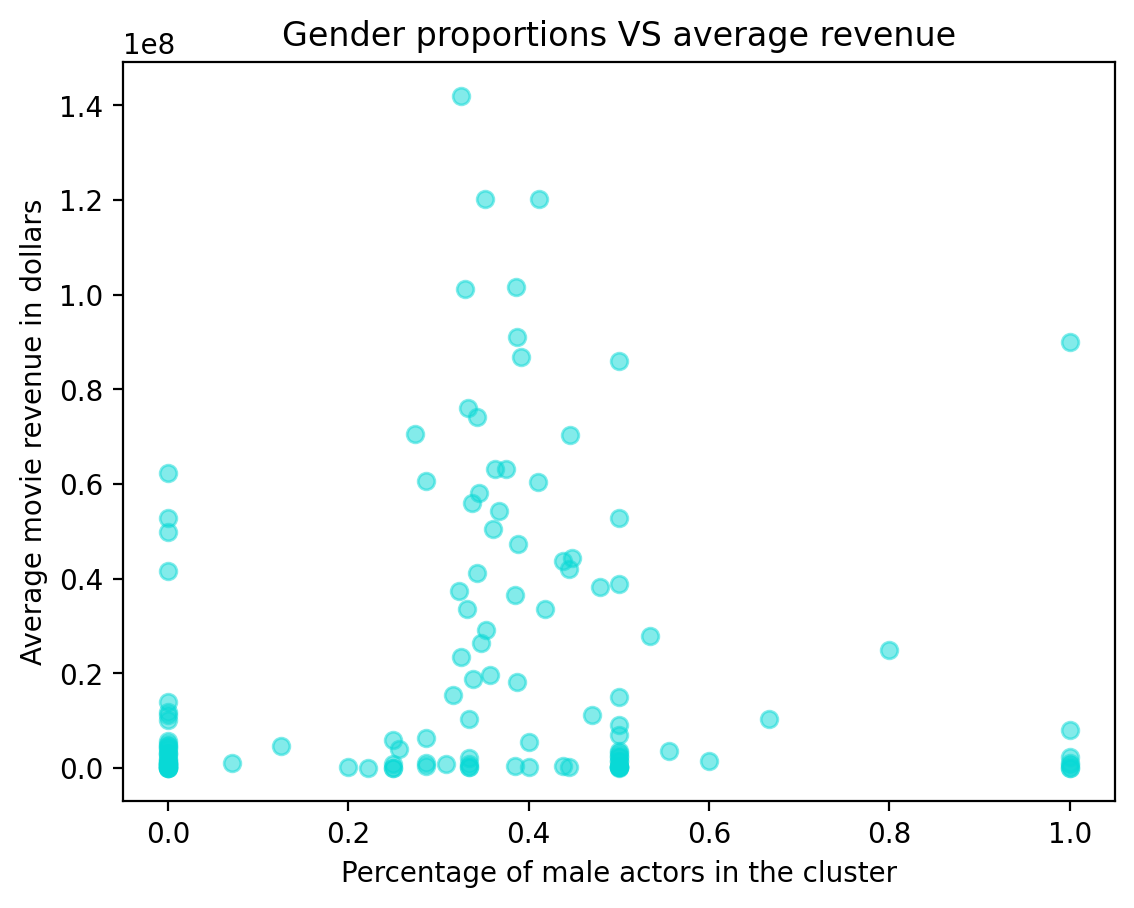

In [89]:
male_proportions, gender_mean_revenues = graph_stats.gender_revenues_graph(plot=True)

In [90]:
from scipy.stats import spearmanr, pearsonr
spearmanr(male_proportions, gender_mean_revenues), pearsonr(male_proportions, gender_mean_revenues)

(SignificanceResult(statistic=0.1295144019305855, pvalue=0.15508359833564192),
 PearsonRResult(statistic=0.12188727677105245, pvalue=0.18108492968996628))

Again, there doesn't seem to be a linear correlation between the average age within the cluster and its success. However, looking at the plot it seems that the clusters with an average age between 30 and 40 years have a greater chance to star in a big movie.

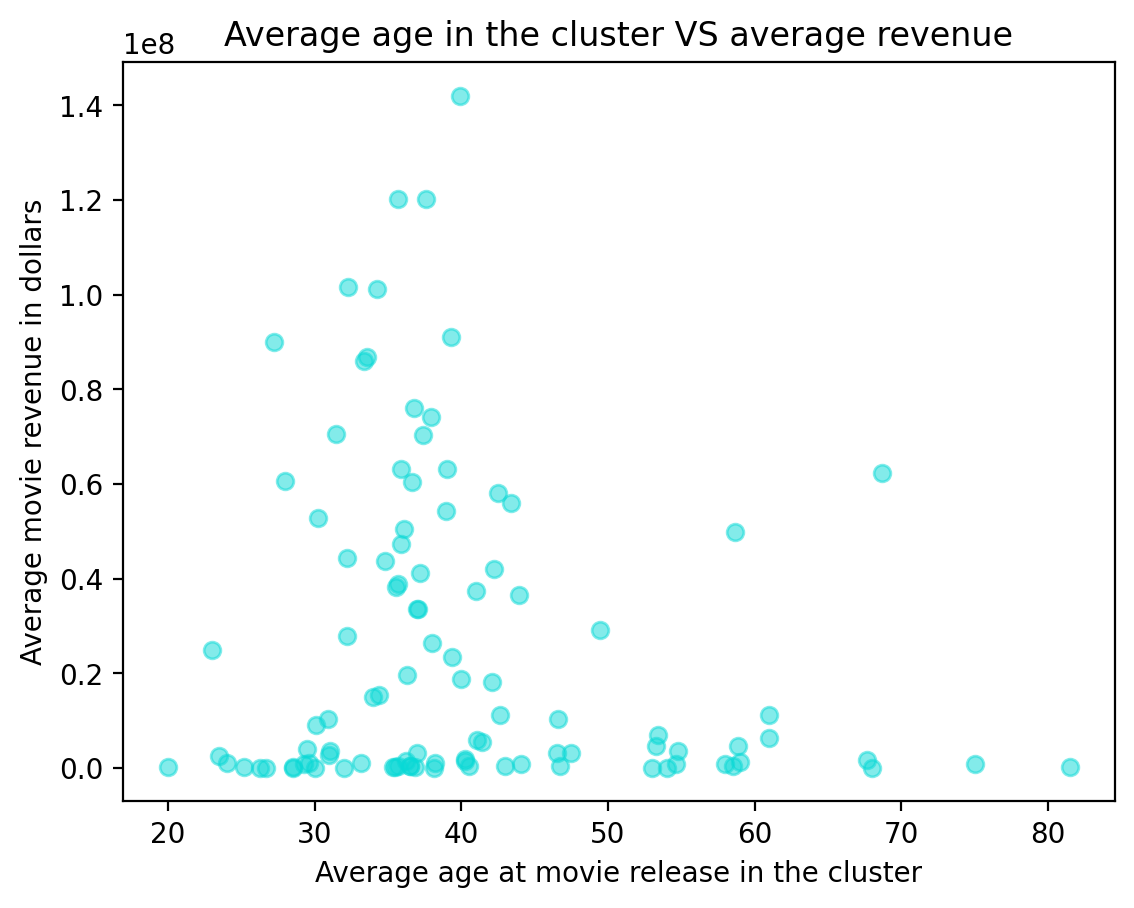

In [91]:
cluster_ages, ages_mean_revenues = graph_stats.age_revenues_graph(plot=True)

In [92]:
spearmanr(cluster_ages, ages_mean_revenues), pearsonr(cluster_ages, ages_mean_revenues)

(SignificanceResult(statistic=-0.0364708006459339, pvalue=0.717288328915892),
 PearsonRResult(statistic=-0.16715517301043006, pvalue=0.09476998263111773))

In conclusion, it seems that group of actors with balanced genders and an average of around 35 years are the most likely to be successful in the US movie industry.

#### B. Top cluster analysis

Let's complement this general analysis with a deeper look inside one of the most successful group of actors in the industry.

In [93]:
from src.utils.actors import Cluster, ActorStats

clusters = [Cluster(characters, us_movies, community) for community in communities_US]
mean_revenues = graph_stats.revenue_distribution()
median_revenues = graph_stats.median_revenue_distribution()

In [94]:
clusters_mean_revenues = sorted(list(zip(clusters, mean_revenues)), key=lambda x: x[1], reverse=True)
top_cluster_mean_revenue = clusters_mean_revenues[0][0]

clusters_median_revenues = sorted(list(zip(clusters, median_revenues)), key=lambda x: x[1], reverse=True)
top_cluster_median_revenue = clusters_median_revenues[0][0]

In [95]:
print(f"""The top cluster in terms of mean revenue ({len(top_cluster_mean_revenue.actor_ids)} actors) had an average revenue of {top_cluster_mean_revenue.cluster_mean_revenue():.0f}$ \
and a median revenue of {top_cluster_mean_revenue.cluster_median_revenue():.0f}$.""")
print(f"""The top cluster in terms of median revenue ({len(top_cluster_median_revenue.actor_ids)} actors) had a median revenue of {top_cluster_median_revenue.cluster_median_revenue():.0f}$ \
and a mean revenue of {top_cluster_median_revenue.cluster_mean_revenue():.0f}$.""")

The top cluster in terms of mean revenue (3979 actors) had an average revenue of 141984940$ and a median revenue of 51316673$.
The top cluster in terms of median revenue (212 actors) had a median revenue of 99274467$ and a mean revenue of 101186712$.


We will now take a closer look at the top cluster in terms of median revenue, which achieved a median revenue of around 99 million dollars. Median revenue is a sign of consistency in producing successfull movies, as opposed to a high average which can be caused by a single hit. In comparison, the top cluster in terms of mean revenue only has around 51 millions dollars of median revenue. Furthermore, the top cluster in terms of median revenue contains a fair amount of actors (212), which helps to make a meaningful analysis.

In [96]:
cluster_actor_names = top_cluster_median_revenue.cluster_actors()
print(f"{len(cluster_actor_names)} actors: {cluster_actor_names}")

212 actors: ['Aaron Cortesi', 'Abbey-May Wakefield', 'Adrien Dorval', 'Alexander Nathan Etel', 'Allan Smith', 'Amber Sainsbury', 'Andrew Miller', 'Andrew Stehlin', 'Andy Pellick', 'Ben Cardinal', 'Ben Derrick', 'Ben Foster', 'Ben Fransham', 'Ben Van Lier', 'Bertina Macauley', 'Bill Dow', 'Buddy the Dog', 'Byron Chief-Moon', 'Cameron Wakefield', 'Camille Keenan', 'Campbell Lane', 'Carl Dixon', 'Carly Owen', 'Chang Tseng', 'Charles Hyatt', 'Chic Littlewood', 'Christopher Coppola', 'Christopher Gaze', 'Craig Hall', 'Curt Ayers', 'David Denis', 'David Lovgren', 'David Palffy', 'Dayna Porter', 'Delilah Cotto', 'Devon Wood', 'Dirk Benedict', 'Dolly Madsen', 'Don Champlin', 'Don Shanks', 'Doug E. Doug', 'Douglas Emerson', 'Duncan Fraser', 'Ed Gale', 'Eddie Deezen', 'Eddie Hassell', 'Edward Campbell', 'Edward Newborn', 'Elizabeth Hawthorne', 'Elizabeth McRae', 'Ellie Cornell', 'Elliot Lawless', 'Emma Fenton', 'Enuka Okuma', 'Eric Eisner', 'Erica Durance', 'Erroll Shand', 'Eugene Blackbear', 'F

In [97]:
whole_us_industry = Cluster(characters, us_movies, [a for c in communities_US for a in c])

This group of actors has about the same gender proportions as the whole industry:

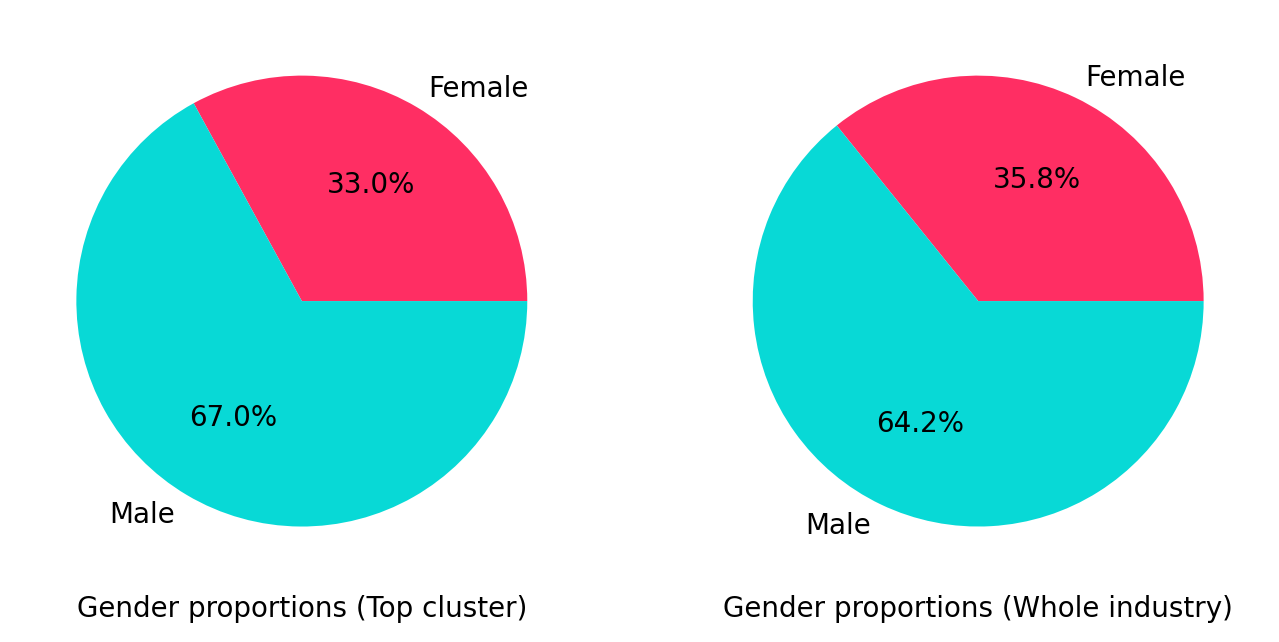

In [98]:
titles = ["Gender proportions (Top cluster)", "Gender proportions (Whole industry)"]
top_cluster_median_revenue.compare_genders_with(whole_us_industry, titles)

In terms of age, this cluster is slightly younger than the rest of the industry:

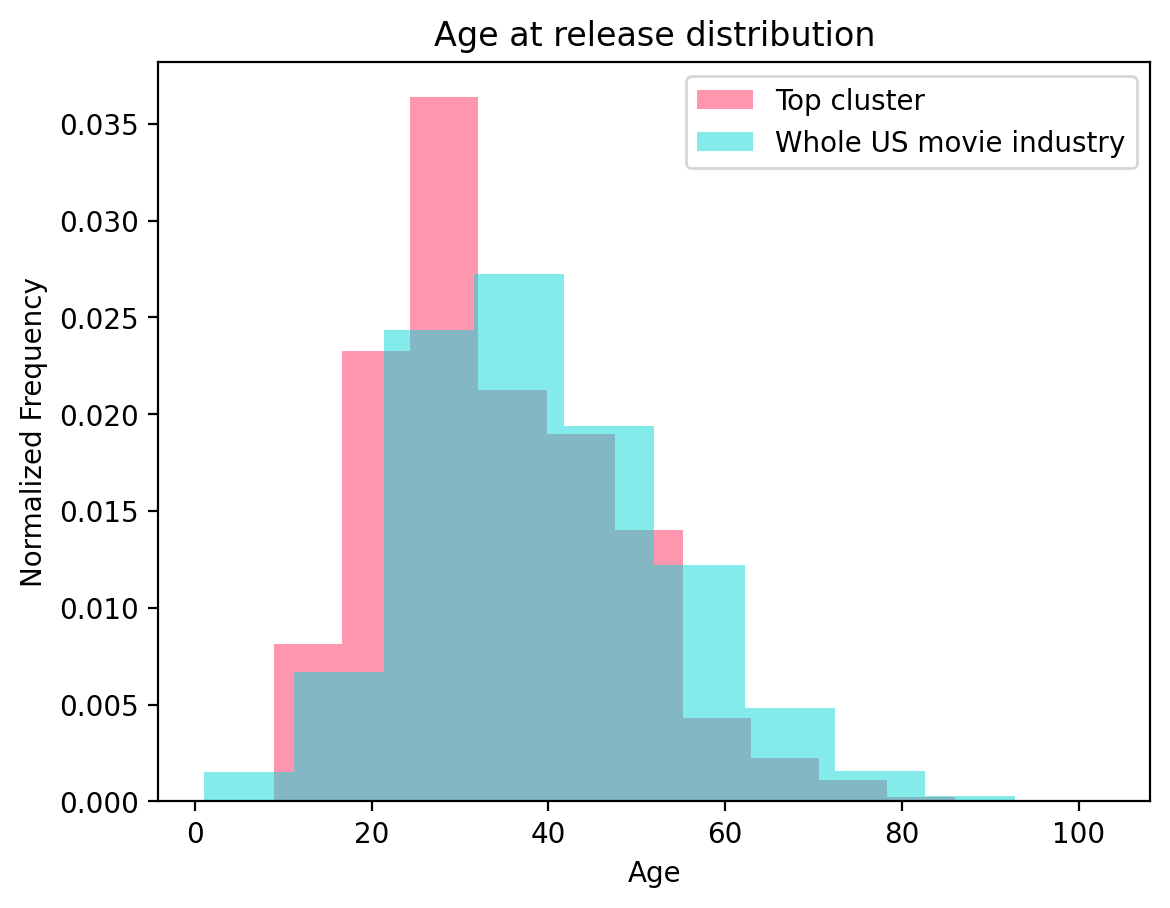

In [69]:
labels = ["Top cluster", "Whole US movie industry"]
top_cluster_median_revenue.compare_ages_with(whole_us_industry, labels)

More than 12 billion dollars were generated by them:

In [70]:
print(f"Total money generated by movies in this cluster: {top_cluster_median_revenue.cluster_total_revenue()}$")

Total money generated by movies in this cluster: 12592219567.0$


By playing in these movies:

In [71]:
top_cluster_movies = top_cluster_median_revenue.cluster_movies()
print(f"{len(top_cluster_movies)} movies: {list(top_cluster_movies['MovieName'])}")

160 movies: ["National Lampoon's Class Reunion", 'Halloween 4: The Return of Michael Myers', 'Camp Nowhere', 'That Thing You Do!', "Cirque du Freak: The Vampire's Assistant", "The General's Daughter", 'RV', 'Sugar & Spice', '40 Days and 40 Nights', 'The Exorcism of Emily Rose', "Child's Play 3", 'MASH', 'Harlem Nights', 'Animal Factory', 'Double Jeopardy', 'House of the Dead', 'Insomnia', 'Friends and Lovers', 'The Lord of the Rings: The Two Towers', 'Best in Show', 'Switchback', 'Halloween 5: The Revenge of Michael Myers', 'Music Within', 'Last of the Dogmen', 'Zathura', 'Secretary', 'Halloween H20: 20 Years Later', 'Cliffhanger', 'The Kids Are All Right', 'Little Manhattan', 'Pearl Harbor', 'Turistas', 'Final Destination 2', 'Mozart and the Whale', 'Frozen River', 'Shark Tale', 'The Way of the Gun', 'Lucky Number Slevin', 'X-Men: The Last Stand', 'Nate and Hayes', '88 Minutes', 'Dark City', 'Keeping the Faith', 'Catwoman', '30 Days of Night', 'Down with Love', 'Above the Rim', 'Vampi

The most profitable movies in that list are:

In [72]:
top_cluster_movies.sort_values(by="Revenue", ascending=False)[["MovieName", "Revenue"]].head(10)

,MovieName,Revenue
8821,The Lord of the Rings: The Two Towers,926047111.0
35156,The Matrix Reloaded,742128461.0
78373,The Hunger Games,686533290.0
73546,King Kong,550500000.0
18469,X-Men: The Last Stand,459359555.0
15862,Pearl Harbor,449220945.0
37723,The Matrix Revolutions,427343298.0
65985,Tron: Legacy,400062763.0
78389,Batman Begins,372710015.0
16587,Shark Tale,367275019.0


"Drama", "Thriller", "Comedy", "Action" and "Adventure" are the prefered genres in this actor group.

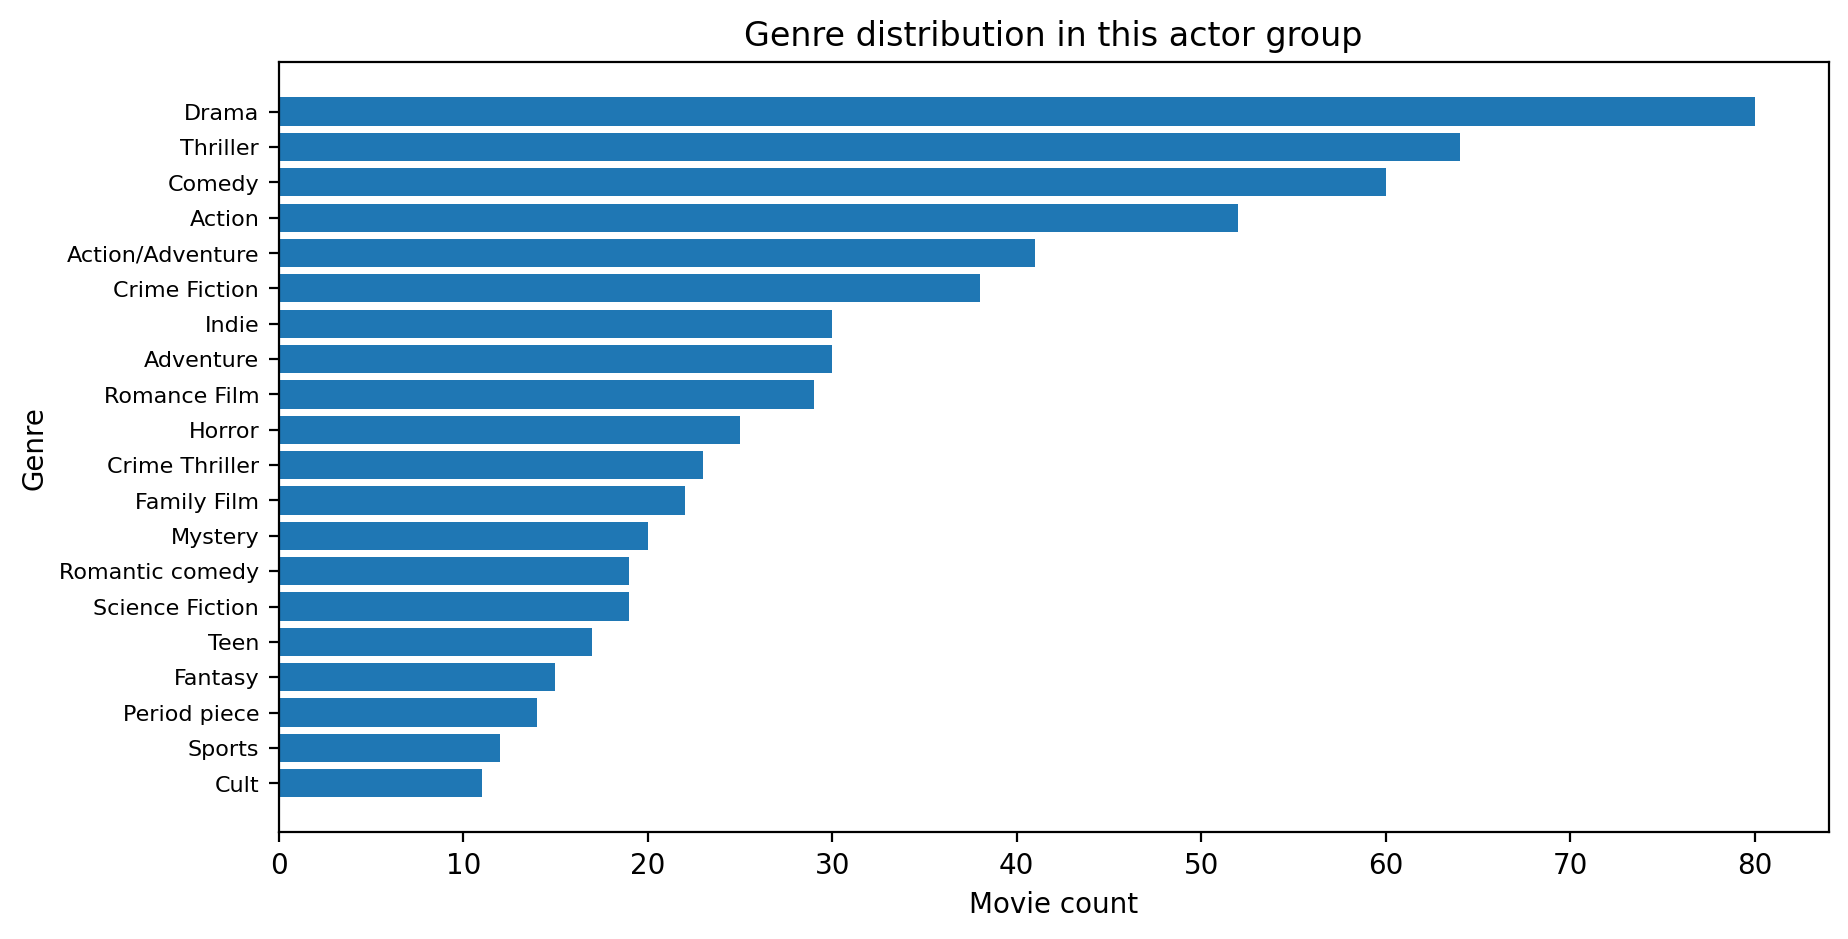

In [73]:
_ = top_cluster_median_revenue.cluster_genres(plot=True)

Let's now have a look at the cluster structure:

In [74]:
actor_stats = ActorStats(characters, us_movies)

In [75]:
top_cluster_graph = G_US.subgraph(top_cluster_median_revenue.actor_ids)
nx.set_node_attributes(top_cluster_graph, 
                       dict([(actor_id, actor_stats.actor_name(actor_id)) for actor_id in top_cluster_graph.nodes()]),
                       'Name')
print(top_cluster_graph)

Graph with 212 nodes and 2118 edges


Who are the most important actors in this cluster? We will use different centrality measures to find out.

To get rid of minor actors, we start by creating a smaller graph where we only keep actors who played in at least 2 movies.

In [76]:
top_cluster_movie_counts = list(zip(top_cluster_median_revenue.actor_ids, 
                               list(map(lambda actor_id: actor_stats.actor_movies(actor_id).shape[0],
                                        top_cluster_median_revenue.actor_ids))))

In [77]:
small_actors = [actor_id for actor_id, movie_count in top_cluster_movie_counts if movie_count < 2]
smaller_graph = top_cluster_graph.copy()
smaller_graph.remove_nodes_from(small_actors)
print(smaller_graph)

Graph with 58 nodes and 233 edges


Katz centrality

In [78]:
from src.utils.networkx_helpers import katz_centrality
katz = katz_centrality(smaller_graph)

Kate S. Butler has katz-centrality: 0.250
Joel Tobeck has katz-centrality: 0.246
Craig Hall has katz-centrality: 0.246
Jared Turner has katz-centrality: 0.241
Elizabeth Hawthorne has katz-centrality: 0.241


Closeness centrality

In [79]:
from src.utils.networkx_helpers import closeness_centrality
closeness = closeness_centrality(smaller_graph)

Josh Hutcherson has closeness-centrality: 0.432
Ed Gale has closeness-centrality: 0.419
Kate S. Butler has closeness-centrality: 0.416
Josh Hartnett has closeness-centrality: 0.380
Eddie Deezen has closeness-centrality: 0.377


Betweenness centrality

In [80]:
from src.utils.networkx_helpers import betweenness_centrality
bet_centrality = betweenness_centrality(smaller_graph)

Josh Hutcherson has betweenness-centrality: 0.359
Ed Gale has betweenness-centrality: 0.296
Kate S. Butler has betweenness-centrality: 0.199
Stephen E. Miller has betweenness-centrality: 0.193
Eddie Deezen has betweenness-centrality: 0.192


To represent the importance of an actor in the community, we'll use the average of the previous centrality measures:

In [81]:
from src.utils.networkx_helpers import importance
importance(smaller_graph, bet_centrality, closeness, katz)

Josh Hutcherson has centrality: 1.000
Kate S. Butler has centrality: 0.975
Ed Gale has centrality: 0.887
Josh Hartnett has centrality: 0.885
Eddie Deezen has centrality: 0.727


We can now visualize the community, where actor names have a font size proportional to their importance in the community. 

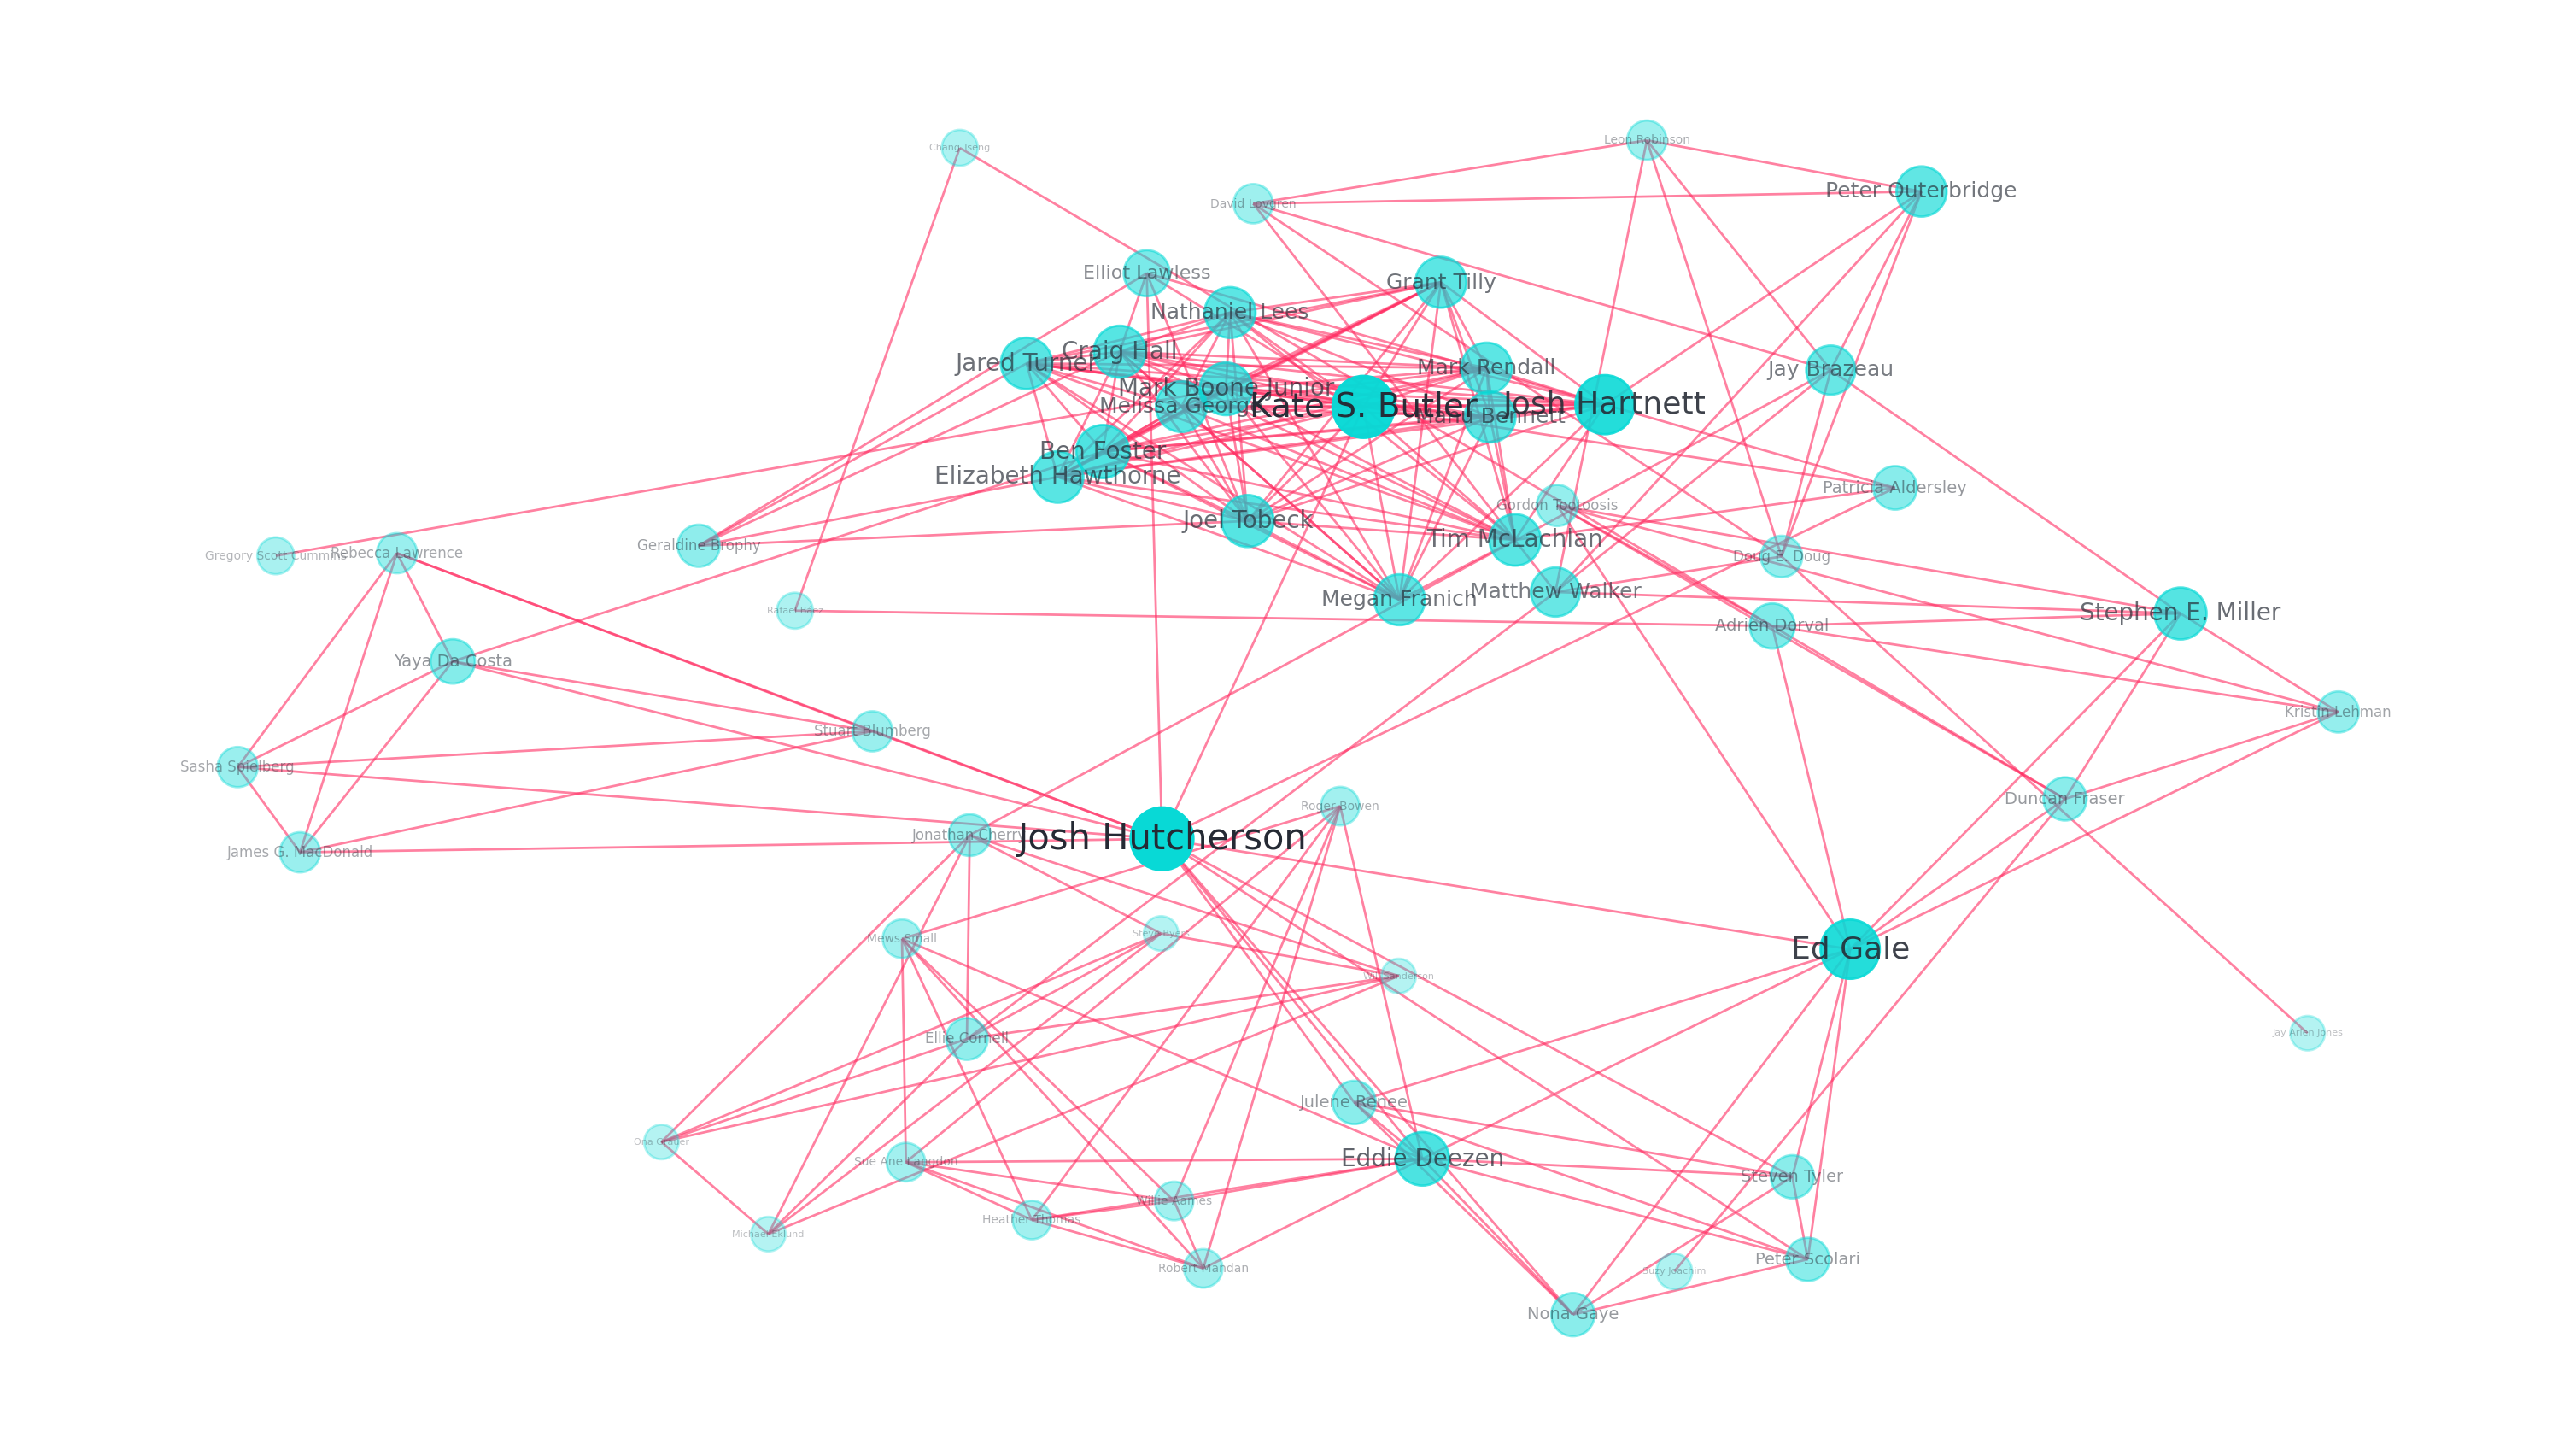

In [82]:
from src.utils.networkx_helpers import visualize_graph
visualize_graph(smaller_graph, "data/results/question2/top_cluster_graph.png", k=0.8, alpha=0.6)